Loss after iteration 0: 0.733871
Loss after iteration 50: 0.302100
Loss after iteration 100: 0.297203
Loss after iteration 150: 0.293393
Loss after iteration 200: 0.175362
Loss after iteration 250: 0.100006
Loss after iteration 300: 0.081750


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


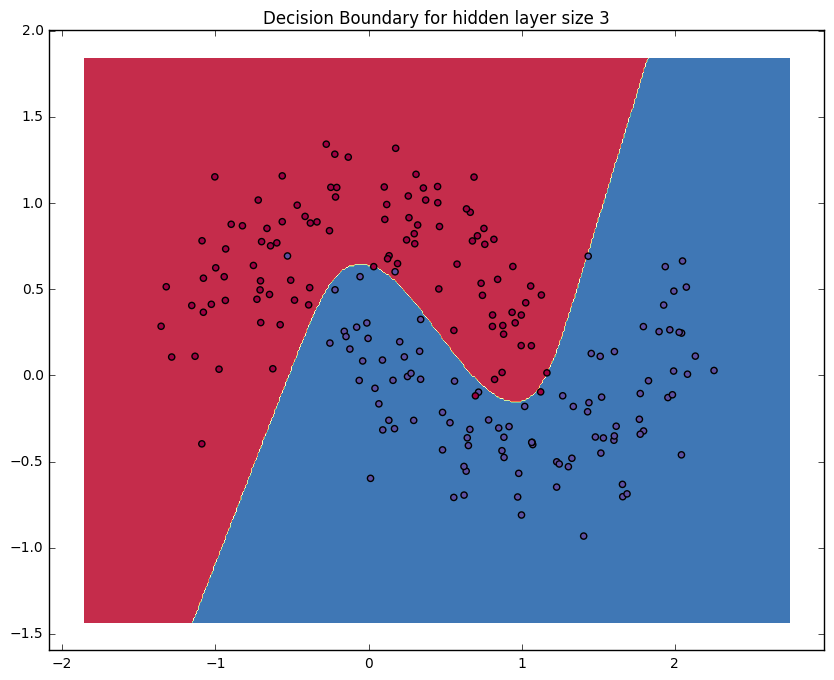

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# 绘图
def plot_decision_boundary(X, y, pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# 配置
num_examples = len(X) # 训练集数据条数
nn_input_dim = 2 # 输入维数
nn_output_dim = 2 # 输出维数
epsilon = 0.01 # 梯度下降学习率
reg_lambda = 0.01 # 标准化强度

def do_work(x, model, target=None):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 计算神经网络的输出
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2) # 将数值映射为正数，就可以不考虑负数的情况
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # 计算每个输出占据总输出的比例，作为选择该分类的概率
        # 不需要每个分类的概率时，也可以直接返回 np.argmax(exp_scores, axis=1)
    
    if target != None:
        # 使用标签数据来纠偏
        delta3 = probs
        delta3[range(num_examples), target] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        model.update({ 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2})
    return probs

def calculate_loss(X, y, model):
    # 计算神经网络输出
    probs = do_work(X, model)
    # 计算与标签值的误差
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    corect_logprobs = -np.log(probs[range(num_examples), y]) # 把标签值对应的预测概率选出来。这些值在 (0,1) 之间。
        # 计算 -log 值，将 (0,1) 映射到 (INF,0)。如果误差小，则选出来的值应该接近 1，-log 之后应该接近 0
    data_loss = np.sum(corect_logprobs) # 所以算出来的 sum 也应该接近 0
    # data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss # 每条训练数据的平均误差

# Helper function to predict an output (0 or 1)
def predict(model, x):
    # 计算每个分类的概率
    probs = do_work(x, model)
    # 返回概率最大的那个分类
    return np.argmax(probs, axis=1) # np里面的操作默认是按列进行（axis=0），axis=1表示按行进行

def build_model(X, y, nn_hdim):
    # 使用随机值来创建初始神经网络
    import time
    np.random.seed(19930928)
    W1 = np.random.uniform(-1,1,(nn_input_dim,nn_hdim))
    b1 = np.random.uniform(-1,1,(1,nn_hdim))
    W2 = np.random.uniform(-1,1,(nn_hdim,nn_output_dim))
    b2 = np.random.uniform(-1,1,(1,nn_output_dim))
    
    # 保存神经网络的最终结果
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # BP方式来更新神经网络
    for i in range(1000):
        # 更新模型
        do_work(X, model, target=y)
        # 误差已经足够小了就退出
        if i % 50 == 0:
            loss = calculate_loss(X, y, model)
            print "Loss after iteration %i: %f" %(i, loss)
            if loss < 0.1:
                break
    return model

# 准备数据
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)

# 使用三个神经元的隐含层
model = build_model(X, y, 3)

# 绘图
plot_decision_boundary(X, y, lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

TypeError: build_model() takes exactly 3 arguments (1 given)

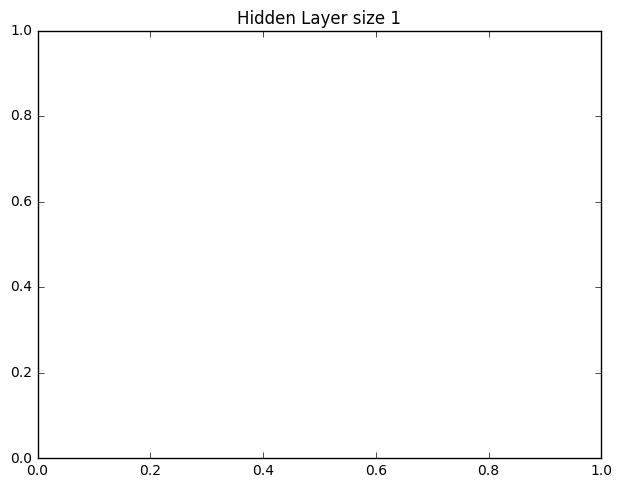

In [99]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
#plt.show()
x

In [ ]:
a=np.array([[1.2,0.5,0.3],
            [0.7,0.1,0.2]])
y=np.array([1,2])

print np.max(a, axis=1)
print a[range(a.shape[0]), y]